In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [0]:
%sql
create or replace temp view tmp_modelo_scr as
select * from base_scr_nt where ds_safra <= 202003

In [0]:
%sql
select ds_safra, cliente_novo, count(*) as qtd from tmp_modelo_scr where group by ds_safra, cliente_novo order by 1

ds_safra,cliente_novo,qtd
201906,1,603
201906,0,1288
201907,0,1605
201907,1,989
201908,1,884
201908,0,1395
201909,1,952
201909,0,1264
201910,0,1417
201910,1,1106


In [0]:
%sql
select ds_safra, fl_sin4 as mau, count(*) as qtd from tmp_modelo_scr group by ds_safra, fl_sin4 order by 1

ds_safra,mau,qtd
201906,1,332
201906,0,1559
201907,0,2192
201907,1,402
201908,1,351
201908,0,1928
201909,1,309
201909,0,1907
201910,1,262
201910,0,2261


In [0]:
%sql
select ds_safra, fl_sin4 as mau, count(*) as qtd from tmp_modelo_scr where cliente_novo <> 1 group by ds_safra, fl_sin4 order by 1

ds_safra,mau,qtd
201906,1,195
201906,0,1093
201907,0,1423
201907,1,182
201908,1,151
201908,0,1244
201909,1,116
201909,0,1148
201910,1,115
201910,0,1302


In [0]:
%sql
select ds_safra, fl_sin4 as mau, count(*) as qtd from tmp_modelo_scr where cliente_novo = 1 group by ds_safra, fl_sin4 order by 1

ds_safra,mau,qtd
201906,1,137
201906,0,466
201907,0,769
201907,1,220
201908,1,200
201908,0,684
201909,1,193
201909,0,759
201910,1,147
201910,0,959


In [0]:
%sql
create or replace temp view decil_scr as 
select
  nr_proposta,
  ds_modelo,
  nr_score,
  fl_sin4,
  ds_safra,
  flag_efetivadas
from tmp_modelo_scr

In [0]:
modelos = ['Sem Familia Produto']

decil_modelos = None

for modelo in modelos:
  
  dt_desenv = 202001
    
  #---------------------------Período Desenv-------------------------------
  
  #Consulta periodo desenvolvimento para geração dos decis
  query = ("select * from decil_scr where ds_modelo = '" + modelo + "' and ds_safra <= " + str(dt_desenv))

  #consulta
  decil_desenv = spark.sql(query).select("*").toPandas()

  #retorna os bins para os decis de desenvolvimento -> Todos, para calculo do PSI
  res, fx_desenv = pd.qcut(decil_desenv['nr_score'], 10, retbins=True)
  
  #caso o modelo retorne algum valor que não existe, estou mudando manualmente os bins
  fx_desenv[0] = -10

  #Volumetria por Decil, podemos verificar que existe uma certa concentração na faixa 4
  decil_desenv = decil_desenv.groupby(pd.qcut(decil_desenv.nr_score, 10))['nr_proposta'].count()

  #DataFrame com os decis do desenvolvimento 
  decil_desenv = pd.DataFrame(decil_desenv).reset_index().reset_index().rename(columns={'index':'gp', 'nr_score':'fx_desenv'})
  decil_desenv['pct_desenv'] = decil_desenv['nr_proposta']/sum(decil_desenv['nr_proposta'])

  
  #------------------------------Produção-------------------------------
  
  #Consulta periodo desenvolvimento para geração dos decis
  query = ("select * from decil_scr where ds_modelo = '" + modelo + "'")

  #Consulta
  decil_prod = spark.sql(query).select("*").toPandas()

  #Realiza as quebras no dataframe de produção
  decil_prod = decil_prod.merge(pd.DataFrame(pd.cut(decil_prod['nr_score'],fx_desenv)).rename(columns={'nr_score':'fx_desenv'}),how='left', right_index=True, left_index=True)

  #Cria os grupos -> o Fillna 0 funciona pois para a primeira faixa a função cut realiza uma quebra menor no primeiro numero
  decil_prod = decil_prod.merge(decil_desenv[['fx_desenv','gp']],how='left',on='fx_desenv').fillna({"gp": 0})

  #Transformo a variavel fx_desenv em string para realizar a conversa em spark dataframe, posteriormente em uma view para criar os graficos stacked 100%
  decil_prod['fx_desenv'] = decil_prod['fx_desenv'].astype(str)
  
  #Appenda o resultado do processamento para uma tabela agrupada
  if decil_modelos is None:
    decil_modelos = decil_prod
  else:
    decil_modelos = decil_modelos.append(decil_prod)
    
#Criando uma view para consulta
spark.createDataFrame(decil_modelos).createOrReplaceTempView('decil_modelos')

In [0]:
%sql
select distinct fx_desenv, gp from decil_modelos order by gp

fx_desenv,gp
"(-10.0, 300.0]",0.0
"(300.0, 367.0]",1.0
"(367.0, 415.0]",2.0
"(415.0, 450.0]",3.0
"(450.0, 478.0]",4.0
"(478.0, 522.0]",5.0
"(522.0, 556.0]",6.0
"(556.0, 600.0]",7.0
"(600.0, 682.0]",8.0
"(682.0, 959.0]",9.0


In [0]:
%sql
select ds_safra, int(gp), count(nr_proposta) as qtd from decil_modelos where ds_modelo = "Sem Familia Produto" group by 1,2 order by 1,2

ds_safra,gp,qtd
201906,0,226
201906,1,178
201906,2,215
201906,3,182
201906,4,168
201906,5,171
201906,6,179
201906,7,195
201906,8,188
201906,9,189


In [0]:
%sql
--criação da view
create or replace temp view tmp_mm_psi as 
select 
    a.ds_modelo,
    a.ds_safra,
    a.fl_sin4,
    a.gp as GH,
    a.fx_desenv,
    --a.nr_score as nr_score,
    count(a.nr_proposta) as QT
from 
    decil_modelos    as a
group by 1,2,3,4,5
order by ds_safra, GH

In [0]:
#DataFrame para guardar os resultados
psi_total = None

for modelo in modelos:
  
  dt_desenv = 202001

  #selecao das safras
  query = "select distinct ds_safra from tmp_mm_psi where ds_safra > "+ str(dt_desenv) +" and ds_modelo = '" + modelo + "' order by ds_safra"
  safras = spark.sql(query).select("*").toPandas()

  #distribuição dos decis nas safras de desenvolvimento
  query = "select GH, sum(qt) as qt from tmp_mm_psi where ds_safra <= "+ str(dt_desenv) +" and ds_modelo = '" + modelo + "' group by 1 order by gh"
  gp_desenv = spark.sql(query).select("*").toPandas()

  gp_desenv['pct_desenv'] = gp_desenv['qt']/sum(gp_desenv['qt'])
  gp_desenv.drop('qt', axis=1, inplace=True)

  #------------------------------------------------------------------------------------------------------------------------------------------------

  #processamento em looping
  for safra in np.array(safras):  

    df_bh = spark.sql("select * from tmp_mm_psi where ds_safra = " + str(safra[0]) + " and ds_modelo = '" + modelo + "'").select("*").toPandas()

    #QUANTIDADE TOTAL
    psi_table = df_bh.groupby(['GH','fx_desenv']).agg({'QT': 'sum'}).reset_index().rename(columns={"QT": "Total"})

    #PERCENTUAL TOTAL
    psi_table['pct_total'] = psi_table['Total']/sum(psi_table['Total'])

    #AGRUPANDO PERCENTUAL DO DECIL PERIODO DESENVOLVIMENTO
    psi_table = psi_table.merge(gp_desenv, how='left', on='GH')

    #PSI
    psi_table['PSI'] = (psi_table['pct_total'] - psi_table['pct_desenv']) * np.log(psi_table['pct_total'] / psi_table['pct_desenv'])

    #modelo
    psi_table['Modelo'] = modelo
    
    #safra
    psi_table['Safra'] = safra[0]

    #Appenda o resultado do processamento para uma tabela agrupada
    if psi_total is None:
      psi_total = psi_table
    else:
      psi_total = psi_total.append(psi_table)

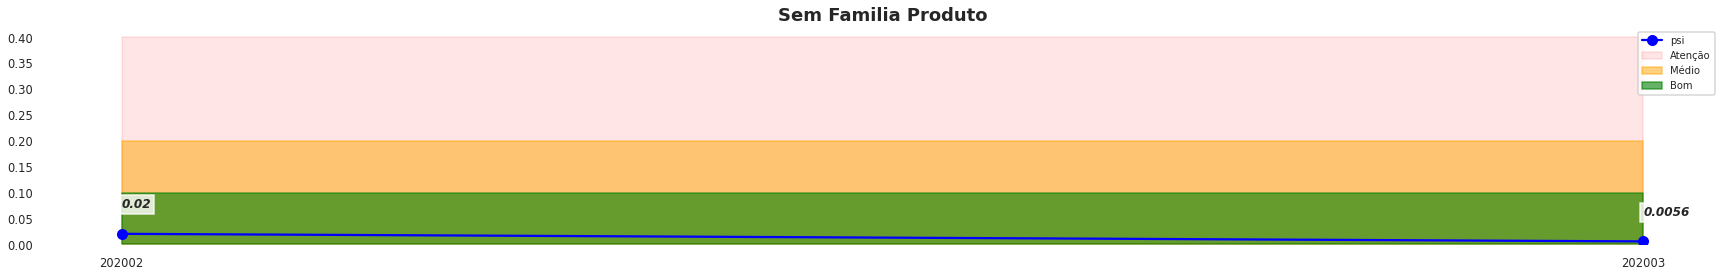

In [0]:
sns.set_style("white")
sns.set_context("talk", font_scale=0.7)

#plot = psi_total.groupby('Safra').agg(psi_tot=('PSI','sum')).reset_index().copy()
#plot = plot[plot['Safra']!='Consolidado'].copy()
#plot = plot[plot['Safra'].astype(int) >= 201912].reset_index()

for modelo in modelos:
  
  plot = psi_total[psi_total['Modelo']==modelo].groupby('Safra').agg(psi_tot=('PSI','sum')).reset_index().copy()
  
  plot['Safra'] = plot['Safra'].astype(str)
  
  if modelo == 'CPC5':
    plot = plot[plot['Safra'].astype(int) < 202008]

  plot['limit_bom'] = 0.1
  plot['limit_med'] = 0.2
  plot['limit_mau'] = 0.4
  f, ax = plt.subplots(1,figsize=(30,4))

  plt.fill_between(plot['Safra'], plot['limit_mau'], label='Atenção', color='red', alpha=0.1)
  plt.fill_between(plot['Safra'], plot['limit_med'], label='Médio', color='orange', alpha=0.5)
  plt.fill_between(plot['Safra'], plot['limit_bom'], label='Bom', color='green', alpha=0.6)

  plt.plot(plot['Safra'], plot['psi_tot'], marker='o',label='psi', color='blue', markersize=10)

  x = plot['Safra']
  y = plot['psi_tot']
  n = plot['psi_tot']

  for i, v in enumerate(n):
    plt.text(x[i], y[i]+0.05, "{:.02}".format(v), fontsize=12, weight='bold', style='italic', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3})

  ax.set_ylim(bottom=0)
  #ax.set_ylim(top=0.5)
  plt.legend(loc='best', fontsize=10)
  plt.title(modelo, fontsize=18, weight='bold')
  sns.despine(bottom = True, left = True)
  plt.show()

In [0]:
#aqui precisamos recalculas os decis para calculo do KS

decil_modelos_efet = None

for modelo in modelos:
  
  dt_desenv = 202001
    
  #---------------------------Período Desenv-------------------------------
  
  #Consulta periodo desenvolvimento para geração dos decis
  query = ("select * from decil_scr where ds_modelo = '" + modelo + "' and ds_safra <= " + str(dt_desenv) )

  #consulta
  decil_desenv = spark.sql(query).select("*").toPandas()

  #retorna os bins para os decis de desenvolvimento -> Todos, para calculo do PSI
  res, fx_desenv = pd.qcut(decil_desenv['nr_score'], 10, retbins=True)
  
  #caso o modelo retorne algum valor que não existe, estou mudando manualmente os bins
  fx_desenv[0] = -10

  #Volumetria por Decil, podemos verificar que existe uma certa concentração na faixa 4
  decil_desenv = decil_desenv.groupby(pd.qcut(decil_desenv.nr_score, 10))['nr_proposta'].count()

  #DataFrame com os decis do desenvolvimento 
  decil_desenv = pd.DataFrame(decil_desenv).reset_index().reset_index().rename(columns={'index':'gp', 'nr_score':'fx_desenv'})
  decil_desenv['pct_desenv'] = decil_desenv['nr_proposta']/sum(decil_desenv['nr_proposta'])

  
  #------------------------------Produção-------------------------------
  
  #Consulta periodo desenvolvimento para geração dos decis
  query = ("select * from decil_scr where ds_modelo = '" + modelo + "'")

  #Consulta
  decil_prod_efet = spark.sql(query).select("*").toPandas()

  #Realiza as quebras no dataframe de produção
  decil_prod_efet = decil_prod_efet.merge(pd.DataFrame(pd.cut(decil_prod_efet['nr_score'],fx_desenv)).rename(columns={'nr_score':'fx_desenv'}),how='left', right_index=True, left_index=True)

  #Cria os grupos -> o Fillna 0 funciona pois para a primeira faixa a função cut realiza uma quebra menor no primeiro numero
  decil_prod_efet = decil_prod_efet.merge(decil_desenv[['fx_desenv','gp']],how='left',on='fx_desenv').fillna({"gp": 0})

  #Transformo a variavel fx_desenv em string para realizar a conversa em spark dataframe, posteriormente em uma view para criar os graficos stacked 100%
  decil_prod_efet['fx_desenv'] = decil_prod_efet['fx_desenv'].astype(str)
  
  #Appenda o resultado do processamento para uma tabela agrupada
  if decil_modelos_efet is None:
    decil_modelos_efet = decil_prod_efet
  else:
    decil_modelos_efet = decil_modelos_efet.append(decil_prod_efet)
    
#Criando uma view para consulta
spark.createDataFrame(decil_modelos_efet).createOrReplaceTempView('decil_modelos_efet')

In [0]:
%sql
create or replace temp view tmp_mm_px_agg as
select 
    a.ds_modelo,
    a.ds_safra,
    a.fl_sin4,
    a.gp as GH,
    a.fx_desenv,
    --a.nr_score as nr_score,
    count(a.nr_proposta) as QT
from 
    decil_modelos_efet    as a
where fl_sin4 is not null and fx_desenv != 'nan' 
group by 1,2,3,4,5
order by ds_safra, GH

In [0]:
#contador de loops
cont = 0

for modelo in modelos:
  #processamento em looping

  #selecao das safras
  safras = spark.sql("select distinct ds_safra from tmp_mm_px_agg where ds_modelo = '" + modelo + "' order by ds_safra").select("*").toPandas()
  
  #Retira safras sem um numero minimo de registros
  if modelo == 'BEHAVIOR':
    safras = safras[safras['ds_safra'].astype(int) >= 201906]
  
  #Adiciona o consolidado para processamento do KS historico
  safras.loc[len(safras)+1] = 'Consolidado'
  
  for safra in np.array(safras):

    if safra[0] == 'Consolidado':
      df_bh = spark.sql("select * from tmp_mm_px_agg where ds_modelo = '" + modelo + "'").select("*").toPandas()
    else:
      df_bh = spark.sql("select * from tmp_mm_px_agg where ds_safra = '" + str(safra[0]) + "' and ds_modelo = '" + modelo + "'").select("*").toPandas()

    df_bh.fillna(0,inplace=True)    

    #BOMS
    gains_table = df_bh.query('fl_sin4 == 0').groupby(['GH','fx_desenv']).agg({'QT': 'sum'}).reset_index().rename(columns={"QT": "qtd_bom"})

    #MAUS
    gains_table = gains_table.merge(df_bh.query('fl_sin4 == 1').groupby('GH').agg({'QT': 'sum'}).reset_index().rename(columns={"QT": "qtd_mau"}) , how='left', on='GH')

    #ALGUNS NÃO POSSUEM CONTRATOS NOS DECIS, PREENCHENDO COM ZEROS
    gains_table.fillna(0, inplace=True)

    #ACUM BONS E MAUS
    gains_table = gains_table.join(gains_table.cumsum().rename(columns={'qtd_bom': 'acum_bom', 'qtd_mau': 'acum_mau'}).drop(['GH','fx_desenv'],axis = 1))

    #TOTAL DE PROPOSTAS
    gains_table['total'] = gains_table['qtd_bom'] + gains_table['qtd_mau']

    #PERCENTUAL DO GRUPO EM RELACAO AO TOTAL
    #gains_table['pct_total'] = (gains_table['qtd_bom'] + gains_table['qtd_mau'])/sum((gains_table['qtd_bom'] + gains_table['qtd_mau']))

    gains_table = gains_table.merge(gp_desenv, how='left', on='GH')

    #BAD INTERVALAR
    gains_table['bad_interval'] = gains_table['qtd_mau'] / gains_table['total']

    #MAU INTERVALAR
    gains_table['mau_intervalar'] = gains_table['qtd_mau'] / sum(gains_table['qtd_mau'])

    #BOM INTERVALAR
    gains_table['bom_intervalar'] = gains_table['qtd_bom'] / sum(gains_table['qtd_bom'])

    #PCT ACUM MAUS
    gains_table['pct_acum_mau'] = gains_table['acum_mau'] / sum(gains_table['qtd_mau'])

    #PCT ACUM BONS
    gains_table['pct_acum_bons'] = gains_table['acum_bom'] / sum(gains_table['qtd_bom'])

    #LAG BONS CALCULO GINI
    calc_gini = gains_table[['GH','pct_acum_bons']].copy()
    calc_gini['GH'] = calc_gini['GH'] + 1
    calc_gini.rename(columns={'pct_acum_bons': 'lag_bons'}, inplace=True)

    gains_table = gains_table.merge(calc_gini, how='left',on='GH')

    #ALGUNS NÃO POSSUEM CONTRATOS NOS DECIS, PREENCHENDO COM ZEROS
    gains_table.fillna(0, inplace=True)

    #PSI
    #gains_table['PSI'] = (gains_table['pct_total'] - gains_table['pct_desenv']) * np.log(gains_table['pct_total'] / gains_table['pct_desenv'])

    #KS2
    gains_table['ks2'] = abs(gains_table['pct_acum_mau'] - gains_table['pct_acum_bons'])

    #gini
    gains_table['Gini'] = gains_table['mau_intervalar'] * (gains_table['pct_acum_bons']+gains_table['lag_bons']) * 0.5

    #safra
    gains_table['Safra'] = safra[0]
    
    #Modelo
    gains_table['Modelo'] = modelo

    if cont == 0:
      gains_total = gains_table
    else:
      gains_total = gains_total.append(gains_table)

    cont += 1

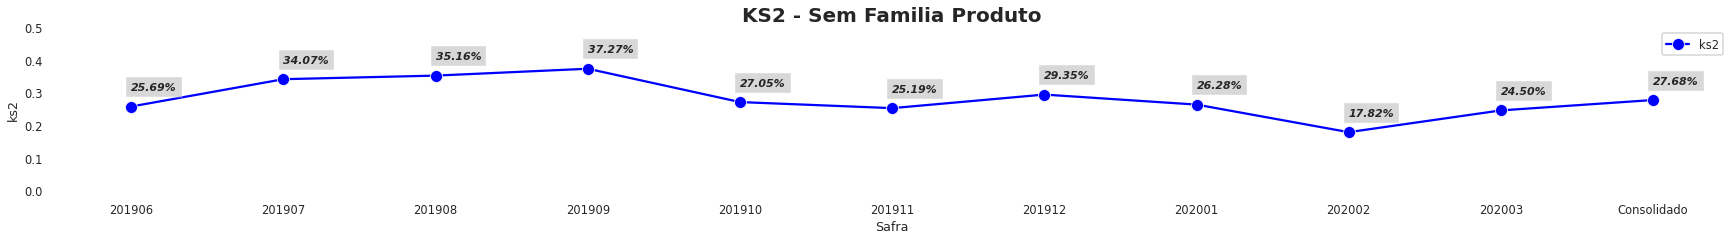

In [0]:
for modelo in modelos:
  
  plot_ks = gains_total[(gains_total['Modelo'] == modelo)].groupby(['Safra']).agg(ks2=('ks2','max')).reset_index().copy()
  plot_ks = plot_ks[plot_ks['ks2'] < 1].reset_index()
  plot_ks['Safra'] = plot_ks['Safra'].astype(str)
  
  f, ax = plt.subplots(1,figsize=(30,3))
  sns.lineplot(data=plot_ks, x='Safra', y='ks2', markers=True, marker='o',label='ks2', color='blue', markersize=12)
  ax.set_ylim(bottom=0.0)
  ax.set_ylim(top=0.5)
  plt.title('KS2 - '+modelo, fontsize=20, weight='bold')

  x = plot_ks['Safra']
  y = plot_ks['ks2']
  n = plot_ks['ks2']

  for i, v in enumerate(n):
    plt.text(x[i], y[i]+0.05, "{:.2%}".format(v), fontsize=11, weight='bold', style='italic', bbox={'facecolor': 'gray', 'alpha': 0.3, 'pad': 5})

  sns.despine(bottom = True, left = True)
  plt.show()

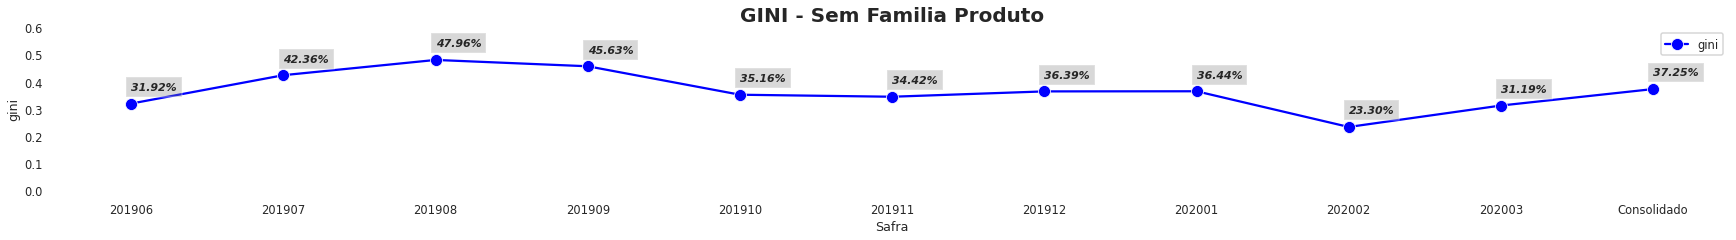

In [0]:
for modelo in modelos:

  plot_gini = gains_total[(gains_total['Modelo'] == modelo)].groupby(['Safra']).agg(auc=('Gini','sum')).reset_index().copy()
  #plot_gini = plot_ks[plot_ks['ks2'] < 1].reset_index()
  plot_gini['gini'] = abs(2*(0.5-plot_gini['auc']))
  plot_gini['Safra'] = plot_gini['Safra'].astype(str)

  plot_gini = plot_gini[plot_gini['gini'] < 1].reset_index()

  f, ax = plt.subplots(1,figsize=(30,3))
  sns.lineplot(data=plot_gini, x='Safra', y='gini', markers=True, marker='o',label='gini', color='blue', markersize=12)
  ax.set_ylim(bottom=0)
  ax.set_ylim(top=0.6)
  plt.title('GINI - ' + modelo, fontsize=20, weight='bold')

  x = plot_gini['Safra']
  y = plot_gini['gini']
  n = plot_gini['gini']

  for i, v in enumerate(n):
    plt.text(x[i], y[i]+0.05, "{:.2%}".format(v), fontsize=11, weight='bold', style='italic', bbox={'facecolor': 'gray', 'alpha': 0.3, 'pad': 5})

  sns.despine(bottom = True, left = True)
  plt.show()


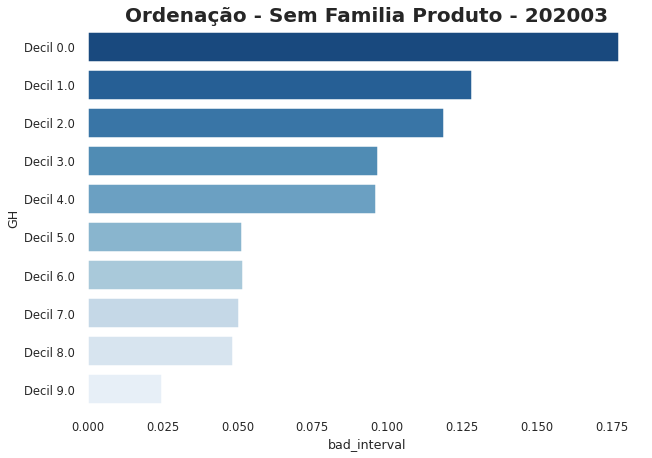

In [0]:
for modelo in modelos:
  
  plot_gh = gains_total[(gains_total['Modelo'] == modelo)].groupby(['Safra']).agg(qtd_mau=('qtd_mau','sum')).reset_index().copy()
  plot_gh = plot_gh[plot_gh['Safra']!='Consolidado'].copy()
  plot_gh = plot_gh[plot_gh['qtd_mau'] > 0].reset_index().drop(['index','qtd_mau'], axis=1)
  
  #buscando dados da ultima diaria com performance
  plot_gh = gains_total[(gains_total['Safra']==plot_gh['Safra'].tail(1).values[0]) & (gains_total['Modelo'] == modelo)].copy()

  plot_gh['GH'] = "Decil " + plot_gh['GH'].astype(str)

  plt.figure(figsize=(10,7))
  g = sns.barplot(x='bad_interval', y='GH', data=plot_gh, palette = 'Blues_r',  color = 'b', ci = None)
  sns.despine(bottom = True, left = True)
  plt.title('Ordenação - '+ modelo +' - ' + str(plot_gh['Safra'].tail(1).values[0]), fontsize=20, weight='bold')
  plt.show()

In [0]:

#bad_fx_score -> Base com os decis
#pct_max_inv  -> Percentual minimo para considerar uma inversao

#função que determina se existem inversões na serie, retornando o ponto onde ocorre a maior inversão
def ponto_inversao(bad_fx_score, pct_max_inv):

  safras = bad_fx_score['ds_safra'].unique()

  bad_transp = None

  #Transpondo os valores da bad rate
  for safra in np.array(safras):
    if bad_transp is None:
      bad_transp = bad_fx_score[bad_fx_score['ds_safra'] == safra][['fx','bad_interval']].rename(columns={'bad_interval': str(safra)})
    else:
      bad_transp = bad_transp.merge(bad_fx_score[bad_fx_score['ds_safra'] == safra][['fx','bad_interval']].rename(columns={'bad_interval': str(safra)}))

  #Criando uma especie de lag nas informações para calcular a diferença entre a linha atual contra a anterior
  lab_bad_transp = bad_transp.reset_index().drop(len(bad_transp)-1)
  lab_bad_transp['index'] = lab_bad_transp['index'] + 1
  lab_bad_transp.drop('fx', axis=1, inplace=True)

  calc_inverse = bad_transp.reset_index().merge(lab_bad_transp, on='index', how='left')

  #Criando uma tabela com as inversôes
  for safra in np.array(safras):
    calc_inverse[str(safra)] = calc_inverse[str(safra) + '_x'] - calc_inverse[str(safra) + '_y']
    calc_inverse.drop(str(safra) + '_x', axis=1, inplace=True)
    calc_inverse.drop(str(safra) + '_y', axis=1, inplace=True)

  calc_inverse.drop('index', axis=1, inplace=True)

  #Verifica se o valor minimo percentual de inversão foi atendido, caso sim, não existe novos agrupamento para serem realizados
  if (max(calc_inverse.drop('fx',axis=1).max() > pct_max_inv)):

    #Buscando o mês e a faixa com a maior inversão
    max_inv = pd.DataFrame(calc_inverse.drop('fx',axis=1).max())[0].max()

    safra_inversao = pd.DataFrame(calc_inverse.drop('fx',axis=1).max())[0][pd.DataFrame(calc_inverse.drop('fx',axis=1).max())[0] == max_inv].reset_index()

    gh_inv = calc_inverse[calc_inverse[safra_inversao['index'][0]]==max_inv].reset_index()['index'][0]

    #retorna o ponto de maior inversão
    return max_inv, safra_inversao['index'][0], gh_inv, calc_inverse
  else:
    #não existe novos agrupamento para serem realizados
    return False

In [0]:
def plot_gh(Title, bad_fx_score):
  plot = bad_fx_score.merge(pd.DataFrame(bad_fx_score['fx'].unique()).reset_index().rename(columns={'index': 'gh', 0: 'fx'}), how='left',on='fx')

  plt.figure(figsize=(30,7))
  plt.title(Title, fontsize=18, weight='bold')
  sns.lineplot(data=plot[['ds_safra','bad_interval','fx']], x='ds_safra', y='bad_interval', hue='fx')
  plt.show()

In [0]:
def plot_bad_interval(bad_fx_score):
  plot_gh_bad = bad_fx_score.groupby('fx').agg(qtd=('qtd','sum'), qtd_mau=('qtd_maus','sum')).reset_index()
  plot_gh_bad['fx'] = plot_gh_bad['fx'].astype(str)
  plot_gh_bad['bad_interval'] = plot_gh_bad['qtd_mau']/plot_gh_bad['qtd']

  #graficos 
  plt.figure(figsize=(30,4))

  sns.barplot(data=plot_gh_bad, x='fx', y='qtd', palette = 'Blues_r')
  ax2 = plt.twinx()
  sns.lineplot(data=plot_gh_bad, x='fx', y='bad_interval', ax=ax2, marker='o', color='gray', markersize=10)

  plt.title('Bad Intervalar x Grupos Homogêneos', fontsize=20, weight='bold')

  x = plot_gh_bad['fx']
  y = plot_gh_bad['bad_interval']
  n = plot_gh_bad['bad_interval']

  for i, v in enumerate(n):
    plt.text(x[i], y[i]+0.01, "{:.2%}".format(v), fontsize=12, weight='bold', style='italic', bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3})

  sns.despine(bottom = True, left = True)
  plt.show()

In [0]:
def grupos_homogeneos(df, var, gp, par_inversao):
  
  first_passage = True
  looping = True

  while looping == True:

    if first_passage:
      #Na primeira passagem do algoritmo, dividimos a base em n valores a partir do parametro
      cuts, fx = pd.qcut(df[var], gp, retbins=True, duplicates='drop')
      first_passage = False
    else:
      #Nas proximas passagens do algoritmo, vamos ajustando as faixas a partir dos grupos que possuem maior inversão
      cuts = pd.cut(df[var], fx)

    df_cuts = df.merge(cuts.rename('fx'),right_index=True,left_index=True)

    bad_fx_score = df_cuts.groupby(['ds_safra','fx']).agg(qtd=('nr_proposta','count'),qtd_maus=('fl_sin4','sum')).reset_index()

    bad_fx_score['bad_interval'] = bad_fx_score['qtd_maus']/bad_fx_score['qtd'] 

    bad_fx_score['bad_interval'].fillna(0, inplace=True)
    
    #plot_gh('Bad Rate Intervalar em ' + (str(len(fx)-1)) + ' Grupos', bad_fx_score)

    #O segundo parametro é uma especie de valor minimo aceitavel para inversões, se ele for positivo, o algoritmo entende que é aceitavel esse limite nas inversões
    #                                                                            se ele for negativo, o algoritmo entende que é o minimo aceitavel de diferença entre as faixas
    retorno = ponto_inversao(bad_fx_score, par_inversao)

    #Se a função retornar "False" não existem inversões.
    if retorno == False:
      print('Não existem inversões para esse grupo')
      looping = False
      
      plot_gh('Bad Rate Intervalar em ' + (str(len(fx)-1)) + ' Grupos', bad_fx_score)
      
      #Função para plotar o grafico da bad intervalar agrupada
      plot_bad_interval(bad_fx_score)
    else:
      vlr_inv = retorno[0]
      safra_inv = retorno[1]
      gh_inv = retorno[2]
      df_inv = retorno[3]

      fx = np.delete(fx,gh_inv)

In [0]:

#Consulta para seleção do modelo
query = ("select * from decil_scr where flag_efetivadas = 1 and ds_safra between 201906 and 202003")

#consulta
df_bh = spark.sql(query).select("*").toPandas()
df_bh['ds_safra'] = df_bh['ds_safra'].astype(str)

Não existem inversões para esse grupo

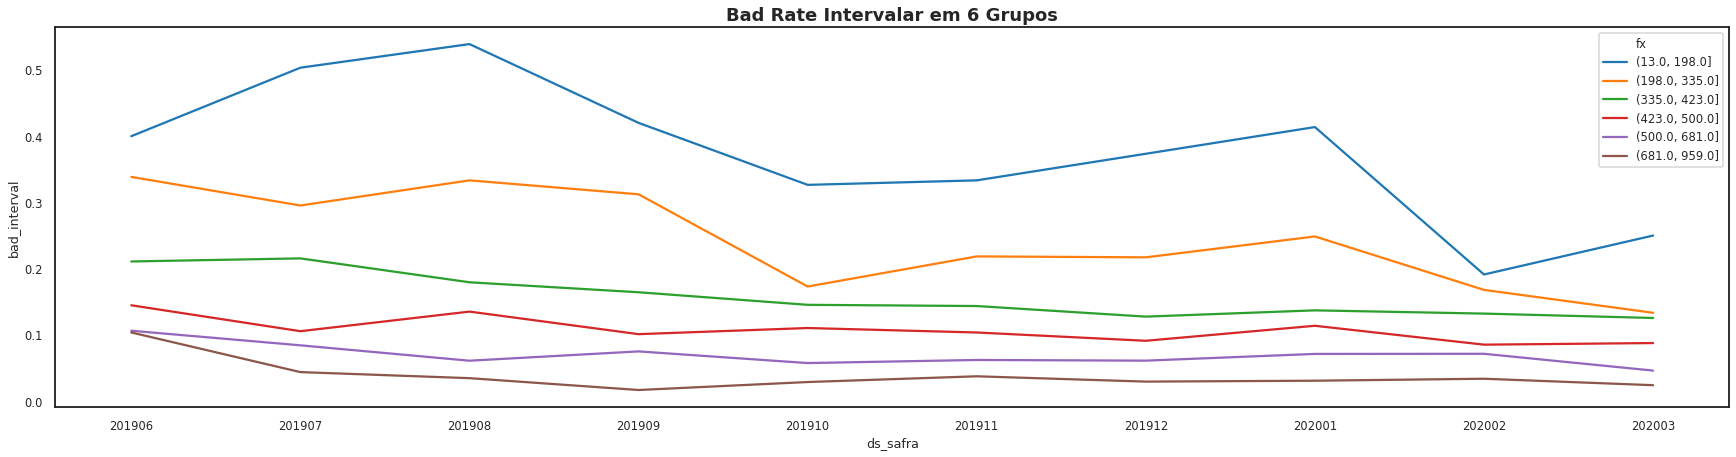

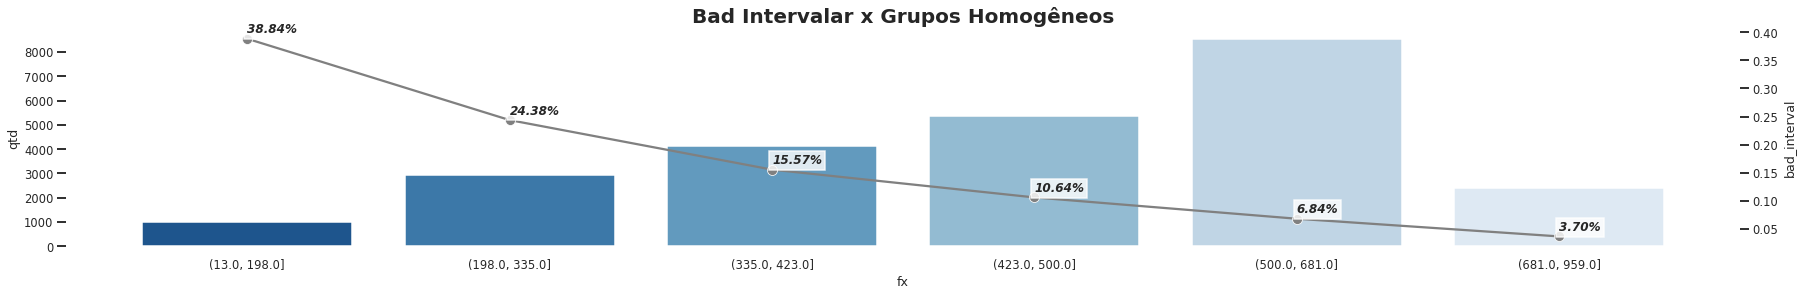

In [0]:
#O quarto parametro é uma especie de valor minimo aceitavel para inversões, se ele for positivo, o algoritmo entende que é aceitavel esse limite nas inversões
#                                                                            se ele for negativo, o algoritmo entende que é o minimo aceitavel de diferença entre as faixas

grupos_homogeneos(df_bh, 'nr_score', 100, 0.00)